**Step 1 : Clone yolov5 repository**

In [10]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5/
!pip install -U -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 15647 (delta 128), reused 170 (delta 96), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.65 MiB | 1.22 MiB/s, done.
Resolving deltas: 100% (10656/10656), done.
/workplace/OpticalRemoteSensingClassification/yolov5_generated_detect/yolov5


In [2]:
# from google.colab import drive 
# drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip  "/workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip" -d training_data

Archive:  /workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip
   creating: training_data/ShipRSImageNet_V1/
   creating: training_data/ShipRSImageNet_V1/COCO_Format/
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipImageNet_train_bnbox_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_2.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_3.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_2.json  
  inflating: training_data/Ship

In [12]:
import torch
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
from random import choice
import shutil
import math
import tensorflow as tf
tf.random.set_seed(420)

In [13]:
def extract_from_xml(xml_file):
    # print(xml_file)
    root = ET.parse(xml_file).getroot()
    # Initialise the dict 
    dict = {}
    dict['bboxes'] = []
    dict['new_width'] = 512
    dict['new_height'] = 512
    # Parse the XML Tree
    for elem in root:
        if os.path.exists(xml_file):
          # Get the file name 
          if elem.tag == "filename":
              dict['filename'] = elem.text

          elif elem.tag == "size":
              image_size = []
              for subelem in elem:
                if subelem.tag == "width":
                  dict['old_width']=int(subelem.text)
                  image_size.append(dict['new_width'])
                elif subelem.tag == "height":
                  dict['old_height']=int(subelem.text)
                  image_size.append(dict['new_height'])
                elif subelem.tag == "depth":
                  image_size.append(int(subelem.text))
              dict['image_size'] = tuple(image_size)
          
          # Get details of the bounding box 
          elif elem.tag == "object":
              bbox = {}
              for subelem in elem:
                  if subelem.tag == "name":
                        bbox['class'] = subelem.text
                      
                  # elif subelem.tag == "rotated_box":
                  #     for subsubelem in subelem:
                  #         bbox[subsubelem.tag] = float(subsubelem.text) 
                  elif subelem.tag == "bndbox":
                      for subsubelem in subelem:
                        if subsubelem.tag == 'xmin' or subsubelem.tag == 'xmax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_width'])/ dict['old_width']
                        elif subsubelem.tag == 'ymin' or subsubelem.tag == 'ymax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_height'])/ dict['old_height']
              dict['bboxes'].append(bbox)
        else:
            break
    return dict
# print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/000160.xml'))
# print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/*'))

In [14]:
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()
# extract from xml file
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)

100%|██████████| 2748/2748 [00:00<00:00, 3183.72it/s]


In [15]:
class_id_mapping= {"Other Ship": 0, "Other Warship": 1, "Submarine": 2, "Other Aircraft Carrier": 3, "Enterprise": 4, "Nimitz": 5, "Midway": 6, "Ticonderoga": 7, "Other Destroyer": 8, "Atago DD": 9, "Arleigh Burke DD": 10, 
                  "Hatsuyuki DD": 11, "Hyuga DD": 12, "Asagiri DD": 13, "Other Frigate": 14, "Perry FF": 15, "Patrol": 16, "Other Landing": 17, "YuTing LL": 18, "YuDeng LL": 19, "YuDao LL": 20, "YuZhao LL": 21, "Austin LL": 22,
                  "Osumi LL": 23, "Wasp LL": 24, "LSD 41 LL": 25, "LHA LL": 26, "Commander": 27, "Other Auxiliary Ship": 28, "Medical Ship": 29, "Test Ship": 30, "Training Ship": 31, "AOE": 32, "Masyuu AS": 33, "Sanantonio AS": 34,
                  "EPF": 35, "Other Merchant": 36, "Container Ship": 37, "RoRo": 38, "Cargo": 39, "Barge": 40, "Tugboat": 41, "Ferry": 42, "Yacht": 43, "Sailboat": 44, "Fishing Vessel": 45,
                  "Oil Tanker": 46, "Hovercraft": 47, "Motorboat": 48, "Dock": 49}

                  
# Convert the info dict to the yolo format and write it to colab
def convert_to_yolov5(dict):
    print_buffer = []
    
    # For each bounding box
    for b in dict["bboxes"]:
        try:
            class_id = class_id_mapping[b["class"]]
        except KeyError:
            print(b["class"])
            print("Invalid Class")
        
        # Transform the bbox co-ordinates as per YOLOv5 format(for obb)
        # xc = b["cx"] * (dict['new_width'] / dict['old_width'])
        # yc = b["cy"] * (dict['new_height'] / dict['old_height'])
        # w  = b["width"] * (dict['new_width'] / dict['old_width'])
        # h  = b["height"] *(dict['new_height'] / dict['old_height'])
        # r =  b["rot"]
        
        # Transform the bbox co-ordinates as per YOLOv5 format
        xc = (b["xmin"] + b["xmax"]) / 2 
        yc = (b["ymin"] + b["ymax"]) / 2
        w  = (b["xmax"] - b["xmin"])
        h  = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates
        image_w, image_h, image_c = dict["image_size"]
        xc /= image_w 
        yc /= image_h 
        w  /= image_w 
        h  /= image_h 
        # r /= 2 * math.pi
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, xc, yc, w, h))
        
    # Name of the file which we have to save 
    save_name = os.path.join("training_data/ShipRSImageNet_V1/VOC_Format/Annotations", dict["filename"].replace("bmp", "txt"))
    # print(save_file_name)
    # Save the annotation to colab
    print("\n".join(print_buffer), file= open(save_name, "w"))

In [16]:
# Get the annotations
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()
# Convert and save the annotations
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)
    convert_to_yolov5(dict)
    os.remove(ann)
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "txt"]

100%|██████████| 2748/2748 [00:01<00:00, 2223.25it/s]


In [17]:
!mkdir dataset
path='./dataset/images/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
path='./dataset/annotations/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
old_name = r"./dataset/annotations/"
new_name = r"./dataset/labels/"
os.rename(old_name, new_name)

In [18]:
#path where annotations are stored 
path='./training_data/ShipRSImageNet_V1/VOC_Format/Annotations/'
count = len(os.listdir(path))
print(count)

array_imgs=[]
array_labels=[]
for (dirname, dirs, files) in os.walk(path):
    for filename in files:
        array_labels.append(filename)
        imgname=os.path.splitext(filename)[0]+'.bmp'
        array_imgs.append(imgname)

# 80% dataset is used for training and 20% for testing
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

#counting range for cycles
countTrain = int(len(array_imgs)*train_ratio)
countVal = int(len(array_labels)*val_ratio)
countTest = int(len(array_labels)*test_ratio)
print("training images are : ",countTrain)
print("Validation images are : ",countVal)
print("Test images are : ",countTest)

2748
training images are :  1923
Validation images are :  549
Test images are :  274


In [19]:
trainImgPath = './dataset/images/train'
trainlabelPath = './dataset/labels/train'
valImgPath = './dataset/images/val'
vallabelPath = './dataset/labels/val'
testImgPath = './dataset/images/test'
testlabelPath = './dataset/labels/test'
imgPath='./training_data/ShipRSImageNet_V1/VOC_Format/cloudy/'


#loop for train
for x in range(int(countTrain)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(trainImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(trainlabelPath, fileXml))

    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for val   
for x in range(int(countVal)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(valImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(vallabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for test   
for x in range(int(countTest)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(testImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(testlabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

In [20]:
# Create .yaml file 
import yaml

data_yaml = {
    'train' : f'./dataset/images/train',
    'val' : f'./dataset/images/val',
    'test' : f'./dataset/images/test',
    'nc' : 50,
    'names' : ['Other Ship', 'Other Warship', 'Submarine', 'Other Aircraft Carrier', 'Enterprise', 'Nimitz', 'Midway', 'Ticonderoga', 'Other Destroyer', 'Atago DD', 'Arleigh Burke DD', 
              'Hatsuyuki DD', 'Hyuga DD', 'Asagiri DD', 'Other Frigate', 'Perry FF', 'Patrol', 'Other Landing', 'YuTing LL', 'YuDeng LL', 'YuDao LL', 'YuZhao LL', 'Austin LL',
              'Osumi LL', 'Wasp LL', 'LSD 41 LL', 'LHA LL', 'Commander', 'Other Auxiliary Ship', 'Medical Ship', 'Test Ship', 'Training Ship', 'AOE', 'Masyuu AS', 'Sanantonio AS',
              'EPF', 'Other Merchant', 'Container Ship', 'RoRo', 'Cargo', 'Barge', 'Tugboat', 'Ferry', 'Yacht', 'Sailboat', 'Fishing Vessel',
              'Oil Tanker', 'Hovercraft', 'Motorboat', 'Dock']
}

    # Note that I am creating the file in the yolov5/data/ directory.
with open(f'./data/ship_custom.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

%cat data/ship_custom.yaml

{names: [Other Ship, Other Warship, Submarine, Other Aircraft Carrier, Enterprise,
    Nimitz, Midway, Ticonderoga, Other Destroyer, Atago DD, Arleigh Burke DD, Hatsuyuki
      DD, Hyuga DD, Asagiri DD, Other Frigate, Perry FF, Patrol, Other Landing, YuTing
      LL, YuDeng LL, YuDao LL, YuZhao LL, Austin LL, Osumi LL, Wasp LL, LSD 41 LL,
    LHA LL, Commander, Other Auxiliary Ship, Medical Ship, Test Ship, Training Ship,
    AOE, Masyuu AS, Sanantonio AS, EPF, Other Merchant, Container Ship, RoRo, Cargo,
    Barge, Tugboat, Ferry, Yacht, Sailboat, Fishing Vessel, Oil Tanker, Hovercraft,
    Motorboat, Dock], nc: 50, test: ./dataset/images/test, train: ./dataset/images/train,
  val: ./dataset/images/val}


In [13]:
# dict['count_train'] = 0
# def extract_from_txt(txt_file):
#     with open(txt_file, 'r') as f:
#      for line in f:
#         # Process each line of the text file
#         # Here, you can split the line by space to extract the values of each detection result
#         # For example:
#         values = line.split()
#         class_id = int(values[0])
#         if class_id == 35:
#            dict['count_train']+=1
#            break

# dir_path= '/content/yolov5/dataset/labels/train/'
# name_list = os.listdir(dir_path)
# for i in name_list:
#   extract_from_txt(os.path.join(dir_path, i))
# print(dict['count_train'])
# # print(extract_from_xml('/content/yolov5/dataset/labels/val/*'))

In [21]:
!python train.py --img 512 --batch 10 --epochs 100 --data ship_custom.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt --project yolov5_classify_cloudy_50class --name yolov5_results --save-period 10 --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: navi71242 (navi12344). Use `wandb login --relogin` to force relogin
train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=ship_custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=10, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_classify_cloudy_50class, name=yolov5_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=10, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

**Validation**

In [31]:
!python val.py --batch 10 --data ship_custom.yaml --weights './yolov5_classify_cloudy_50class/yolov5_results/weights/best.pt' --task test --project yolov5_classify_cloudy_50class --name 'Validation' --augment --verbose

val: data=/workplace/OpticalRemoteSensingClassification/yolov5/data/ship_custom.yaml, weights=['./yolov5_classify_cloudy_50class/yolov5_results/weights/best.pt'], batch_size=10, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_classify_cloudy_50class, name=Validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86503135 parameters, 0 gradients, 204.8 GFLOPs
test: Scanning /workplace/OpticalRemoteSensingClassification/yolov5/dataset/labe
test: WARNING ⚠️ /workplace/OpticalRemoteSensingClassification/yolov5/dataset/images/test/2487__0_1498.bmp: 1 duplicate labels removed
test: New cache created: /workplace/OpticalRemoteSensingClassification/yolov5/dataset/labels/test.cache
          

**Run YOLO5 Inference on test images** 

In [32]:
!python detect.py --weights './yolov5_classify_cloudy_50class/yolov5_results/weights/best.pt' --img 512 --conf 0.4 --source ./dataset/images/test --iou 0.45 --augment --project 'yolov5_classify_cloudy_50class' --name 'classify_test' --line-thickness 1

detect: weights=['./yolov5_classify_cloudy_50class/yolov5_results/weights/best.pt'], source=./dataset/images/test, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_classify_cloudy_50class, name=classify_test, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-163-g016e046 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86503135 parameters, 0 gradients, 204.8 GFLOPs
image 1/274 /workplace/OpticalRemoteSensingClassification/yolov5/dataset/images/test/000040.bmp: 512x512 1 Other Warship, 1 Hatsuyuki DD, 1 Other Frigate, 1 AOE, 1 Dock, 104.9ms
image 2/274 /workplace/OpticalRemoteSensingClassification/yolov5/dataset/images/test/000059

In [36]:
!zip -r results_classify_cloudy_50class.zip yolov5_classify_cloudy_50class

updating: yolov5_classify_cloudy_50class/ (stored 0%)
updating: yolov5_classify_cloudy_50class/yolov5_results/ (stored 0%)
updating: yolov5_classify_cloudy_50class/yolov5_results/F1_curve.png (deflated 9%)
updating: yolov5_classify_cloudy_50class/yolov5_results/PR_curve.png (deflated 7%)
updating: yolov5_classify_cloudy_50class/yolov5_results/P_curve.png (deflated 8%)
updating: yolov5_classify_cloudy_50class/yolov5_results/R_curve.png (deflated 9%)
updating: yolov5_classify_cloudy_50class/yolov5_results/confusion_matrix.png (deflated 17%)
updating: yolov5_classify_cloudy_50class/yolov5_results/events.out.tfevents.1683611780.76f2ba8b81a9.403127.0 (deflated 24%)
updating: yolov5_classify_cloudy_50class/yolov5_results/hyp.yaml (deflated 45%)
updating: yolov5_classify_cloudy_50class/yolov5_results/labels.jpg (deflated 22%)
updating: yolov5_classify_cloudy_50class/yolov5_results/labels_correlogram.jpg (deflated 32%)
updating: yolov5_classify_cloudy_50class/yolov5_results/opt.yaml (deflated 

In [ ]:
# import shutil
# shutil.copy("results_classify_cloudless.zip","/content/drive/MyDrive/NITC_project/")

'/content/drive/MyDrive/NITC_project/results_classify_cloudless.zip'

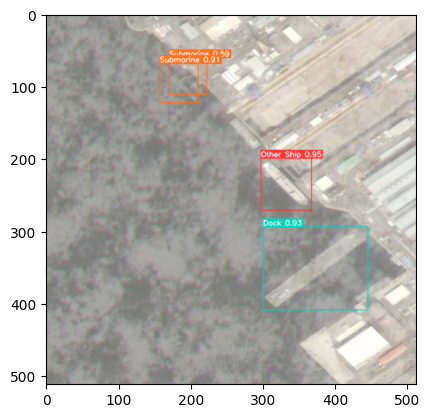

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = './yolov5_classify_cloudy_50class/classify_test/000059.bmp'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

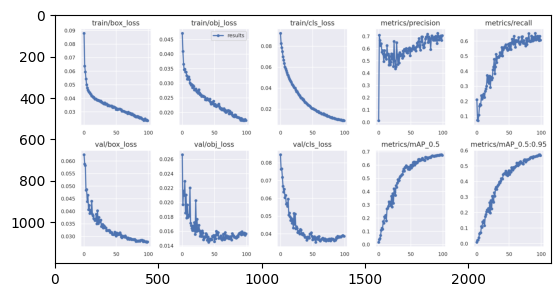

In [38]:
img_path = './yolov5_classify_cloudy_50class/yolov5_results/results.png'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

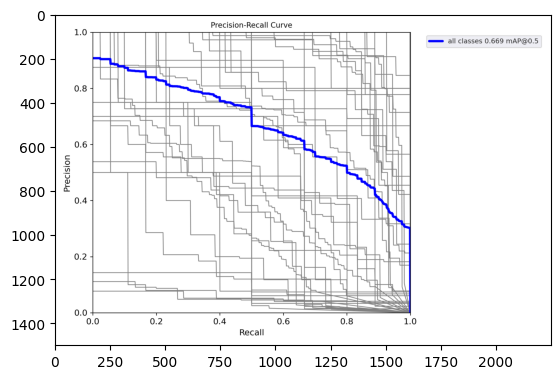

In [39]:
img_path = './yolov5_classify_cloudy_50class/Validation/PR_curve.png'
# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

**Step 5: Display image in colab**

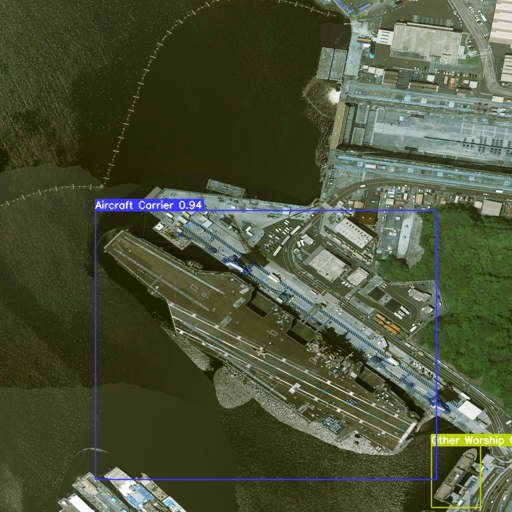

In [ ]:
from google.colab.patches import cv2_imshow
from skimage import io
img_path='./runs/detect/infer_results/000003.bmp'
image=io.imread(img_path)
cv2_imshow(image)

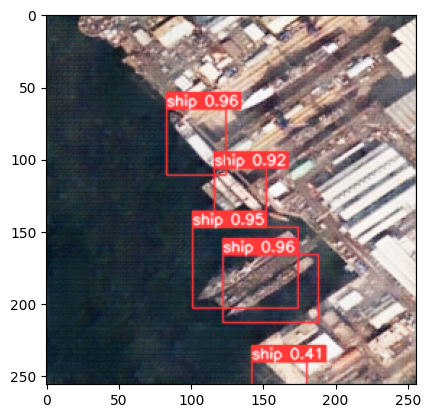

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img_path = './runs/detect/infer_results/000037.bmp'

# # Load image
# img = mpimg.imread(img_path)

# # Display image
# plt.imshow(img)
# plt.show()